## LandCoverNet Model Training

<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

This tutorial delves into building a scalable model on the LandCoverNet dataset.

This portion of the tutorial is focused on developing a semantic segmentation model for LandCoverNet data
Here:

1. We will inspect the source imagery for the labels we have

2. We will process the source imagery in parallel using Dask

3. We will select some labels and source images from Dask to be loaded into our segmentation model

4. We will build a segmentation model, train it on the data and inspect the results

#### Store your MLHub API Developer Key

In [1]:
import getpass

MLHUB_API_KEY = getpass.getpass(prompt="MLHub API Key: ")
MLHUB_ROOT_URL = "https://api.radiant.earth/mlhub/v1"

MLHub API Key:  ································································


In [6]:
import pystac
import os
import itertools as it
import pystac_client
import requests
import shapely.geometry
from shapely.geometry import mapping, shape
import rioxarray
from pystac import Item
from typing import List, Tuple

import stackstac
import rasterio as rio
import rasterio.plot
import numpy as np
import pandas as pd
import dask
from pystac.item_collection import ItemCollection
from pystac.extensions.eo import EOExtension

import contextlib
import warnings
from pystac.extensions.label import LabelExtension, LabelRelType
from urllib.parse import urljoin

from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

#### Instantiate an instance of the MLHub API Client

In [7]:
mlhub_client = pystac_client.Client.open(
    url=MLHUB_ROOT_URL,
    parameters={"key": MLHUB_API_KEY},
    ignore_conformance=True
)

In [8]:
tmp_dir = "/home/jovyan/PlanetaryComputerExamples"
if not os.path.isdir(f"{tmp_dir}/landcovnet/labels"):
    os.makedirs(f"{tmp_dir}/landcovnet/labels") #create folder for labels to be stored

#### Loading the source imagery

The esip-summer-2021-geospatial-ml tutorial was helpful in this task, which can be found [here](https://github.com/TomAugspurger/esip-summer-2021-geospatial-ml/blob/main/segmentation-model.ipynb)

It was particularly useful for loading the STAC items and Sentinel-2 scenes

In [9]:
#check for data in collection file
catalog = pystac.read_file(
    tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/collection.json"
)

In [8]:
from dask.distributed import Client

client = Client()
client.run(lambda: warnings.filterwarnings("ignore", "Creating an ndarray from ragged"))

{'tcp://127.0.0.1:35039': None,
 'tcp://127.0.0.1:39587': None,
 'tcp://127.0.0.1:41747': None,
 'tcp://127.0.0.1:44997': None}

In [ ]:
#client.shutdown() #use this if you want to shutdown dask client

Here, we will select `n` labels with their respective source images for processing

In [10]:
links = catalog.get_item_links() #links from the catalog
label_items = [link.resolve_stac_object().target for link in links]

In [11]:
n=15 #we will select 15 labels to use here
label_items=label_items[0:0+n]

In [9]:
label_items

[<Item id=ref_landcovernet_v1_labels_37PCM_22>,
 <Item id=ref_landcovernet_v1_labels_35PNR_13>,
 <Item id=ref_landcovernet_v1_labels_34MBC_18>,
 <Item id=ref_landcovernet_v1_labels_37NGE_11>,
 <Item id=ref_landcovernet_v1_labels_33KXV_06>,
 <Item id=ref_landcovernet_v1_labels_35PNR_11>,
 <Item id=ref_landcovernet_v1_labels_32PLS_01>,
 <Item id=ref_landcovernet_v1_labels_35JNN_07>,
 <Item id=ref_landcovernet_v1_labels_35PNR_18>,
 <Item id=ref_landcovernet_v1_labels_35PNR_20>,
 <Item id=ref_landcovernet_v1_labels_37NGE_16>,
 <Item id=ref_landcovernet_v1_labels_35PNR_15>,
 <Item id=ref_landcovernet_v1_labels_35PNR_16>,
 <Item id=ref_landcovernet_v1_labels_38PKQ_23>,
 <Item id=ref_landcovernet_v1_labels_35PNR_14>]

In [12]:
#obtain bounding boxes for each label
bboxes = np.array([label_item.bbox for label_item in label_items])
mins = bboxes.min(0)
maxes = bboxes.max(0)
bbox = mins[0], mins[1], maxes[2], maxes[3]

In [13]:
temporal_start = catalog.extent.temporal.intervals[0][0].strftime("%Y-%m-%d") # global starting datetime for label Collection
temporal_end = catalog.extent.temporal.intervals[0][1].strftime("%Y-%m-%d") # global ending datetime for label Collection
assets = ("B04", "B03", "B02") # we will make use of the RGB bands

In [14]:
def get_season_min_cloud_cover(item_list: List[Item]) -> ItemCollection:
    
    """Takes a list of source Items and returns a single chip per season
    ranked by the minimum cloud cover from eo:cloud_cover property
    
    Args:
    item_list: List[Item] - iterable of source Items returned from search
    
    Returns:
    ItemCollection - STAC Iterable containing Items filtered by cloud cover
    """
    
    df_list = []
    for ui in item_list:
        if 'eo:cloud_cover' in ui.properties:
            cloud_cover = ui.properties['eo:cloud_cover']
        else:
            cloud_cover = 0
        uid = {
            'item': ui,
            'id': ui.id,
            'cloud_cover': cloud_cover,
            'date_time': ui.datetime
        }
        df_list.append(uid)
        
    cc_df = pd.DataFrame(df_list)
    
    if not cc_df.empty:
        cc_df['date_time'] = pd.to_datetime(cc_df['date_time'])
        cc_df['quarter'] = cc_df['date_time'].dt.quarter
        cc_df['rank'] = cc_df.groupby("quarter")["cloud_cover"].rank(method="first", ascending=False)

        return ItemCollection(cc_df[cc_df['rank']==1]['item'].tolist())
    
    return None

In [15]:
def get_label_item_collection(label_item: Item) -> ItemCollection:
    
    """Takes a label Item from the LandCoverNet Collection and searches
    for source imagery for chips that match spatial and temporal criteria
    
    Args:
    label_item: Item - item of current iteration in the get_item() Dask parallelization
    
    Returns:
    ItemCollection - STAC Iterable containing Items that match search criteria
    """

    search = mlhub_client.search(
        collections=['ref_landcovernet_v1_source'],
        intersects=mapping(shape(label_item.geometry)),
        datetime=[temporal_start, temporal_end],
        # query={"eo:cloud_cover": {"lt": 10}},
    )
    
    return get_season_min_cloud_cover(search.get_all_items().items)

In [16]:
#code reference from https://github.com/TomAugspurger/esip-summer-2021-geospatial-ml/blob/main/segmentation-model.ipynb

#This function will load source imagery and label into xarray for further processing
def get_item(label_item: Item, assets: Tuple[str]) -> (np.ndarray, np.ndarray):
    
    """Takes label Item and asset bands to construct n-darrays for model training
    
    Args:
    label_item: Item - item of current iteration in the get_item() Dask parallelization
    assets: Tuple[str] - a set of strings corresponding to the Asset band names
    
    Returns:
    data: np.ndarray, labels: np.ndarray - X and y n-darrays for model training
    """
    
    assets = list(assets)
    labels = rioxarray.open_rasterio(
        tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/"+label_item.id+"/labels.tif",
    ).squeeze()
    
    source_item_collection = get_label_item_collection(label_item)
    
    if len(source_item_collection) > 0:
    
        bounds = tuple(round(x, 0) for x in labels.rio.bounds())
        print(f'Bounds of the label item: \n{bounds}')

        data = (
                stackstac.stack(
                    items=source_item_collection,
                    assets=assets,
                    dtype="float32",
                    resolution=10,
                    bounds=bounds,
                    epsg=labels.rio.crs.to_epsg(),
                )
            )
            #assert data.shape[1:] == labels.shape
        data = data.assign_coords(x=labels.x.data, y=labels.y.data)
        data /= 4000
        data = np.clip(data, 0,1)
        
        return data, labels.astype("int64")

#### Extracting Source Imagery

Let's find the the source imagery associated with those labels by examining the Item links (source imagery links will have a `"rel"` type of `"source"`.

#### Loading the source imagery from their respective links

In [35]:
Xys=[]
get_item_ = dask.delayed(get_item, nout=2)

Xys.append([get_item_(label_item, image_item, assets) for label_item in label_items])
Xys = dask.persist(*Xys)

Xys = dask.compute(*Xys)

In [17]:
gets=[]
gets.append([get_item(label_item, assets) for label_item in label_items])

Bounds of the label item: 
(317110.0, 1146140.0, 319670.0, 1148700.0)
Bounds of the label item: 
(593650.0, 1541220.0, 596210.0, 1543780.0)
Bounds of the label item: 
(252290.0, 9741880.0, 254850.0, 9744440.0)
Bounds of the label item: 
(727000.0, 469080.0, 729560.0, 471640.0)
Bounds of the label item: 
(600980.0, 7941280.0, 603540.0, 7943840.0)
Bounds of the label item: 
(577130.0, 1511010.0, 579690.0, 1513570.0)
Bounds of the label item: 
(324210.0, 1162080.0, 326770.0, 1164640.0)
Bounds of the label item: 
(526480.0, 7252580.0, 529040.0, 7255140.0)
Bounds of the label item: 
(558500.0, 1551050.0, 561060.0, 1553610.0)
Bounds of the label item: 
(540190.0, 1494290.0, 542750.0, 1496850.0)
Bounds of the label item: 
(731380.0, 439290.0, 733940.0, 441850.0)
Bounds of the label item: 
(521660.0, 1580750.0, 524220.0, 1583310.0)
Bounds of the label item: 
(525640.0, 1503130.0, 528200.0, 1505690.0)
Bounds of the label item: 
(228240.0, 975040.0, 230800.0, 977600.0)
Bounds of the label item: 

In [18]:
gets=gets[0]

In [45]:
# samp=[]
# for i in range (0, len(Xys[0])):
#     samp.append(Xys[0][i][0].data)

In [19]:
samp=[]
for i in range (0, len(gets)):
    samp.append(gets[i][0].data)

In [20]:
samp = [it for sub in samp for it in sub]
arr = np.asarray(samp)
swapped = arr.swapaxes(1,2)
swapped = swapped.swapaxes(2,3)
X=swapped

In [25]:
len(X)

60

In [21]:
total=0
total_list=[]
for i in range(0,len(gets)):
    total+=len(gets[i][0])
    total_list.append(total)

In [45]:
# total=0
# total_list=[]
# for i in range(0,len(Xys[0])):
#     total+=len(Xys[0][i][0])
#     total_list.append(total)

In [27]:
total_list

[4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60]

In [22]:
Y= np.zeros((total, 256, 256), dtype=np.float32)
i=0
for j in range(0, len(total_list)):
    Y[i:total_list[j]]=gets[j][1][0].data
    i=total_list[j]

In [47]:
# Y= np.zeros((total, 256, 256), dtype=np.float32)
# i=0
# for j in range(0, len(total_list)):
#     Y[i:total_list[j]]=Xys[0][j][1][0].data
#     i=total_list[j]

In [23]:
X=np.array(X)
Y=np.array(Y)

In [80]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [114]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(test_label1.shape)
print(test_label2.shape)

(42, 256, 256, 3)
(42, 256, 256)
(9, 256, 256, 3)
(9, 256, 256)
(256, 256)
(256, 256)


In [53]:
X.shape

(60, 256, 256, 3)

### Building the model

We will make use of semantic segmentation using U-Net.

This model was thanks to CHANYOUNG KIM on Kaggle's  Aerial Semantic Segmentation Drone Dataset.

Their implementation can be found [here](https://www.kaggle.com/kimchanyoung/implementation-of-mobileunet-in-tensorflow)


In [26]:
#https://www.kaggle.com/kimchanyoung/implementation-of-mobileunet-in-tensorflow?scriptVersionId=73428275&cellId=10
def unet(input_size, num_classes):
    inputs = Input(input_size)

    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1  = BatchNormalization()(conv1)
    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1  = BatchNormalization()(conv1)
    pool1  = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2  = BatchNormalization()(conv2)
    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2  = BatchNormalization()(conv2)
    pool2  = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3  = BatchNormalization()(conv3)
    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3  = BatchNormalization()(conv3)
    pool3  = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4  = BatchNormalization()(conv4)
    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4  = BatchNormalization()(conv4)
    pool4  = MaxPooling2D(pool_size=(2, 2))(conv4)    
    
    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5  = BatchNormalization()(conv5)
    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5  = BatchNormalization()(conv5)
    
    conv6  = Conv2DTranspose(512, 3, strides=(2, 2), activation='relu', padding='same')(conv5)
    cat6   = concatenate([conv4, conv6], axis = 3)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(cat6)
    conv6  = BatchNormalization()(conv6)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6  = BatchNormalization()(conv6)
    
    conv7  = Conv2DTranspose(256, 3, strides=(2, 2), activation='relu', padding='same')(conv6)
    cat7   = concatenate([conv3, conv7], axis = 3)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(cat7)
    conv7  = BatchNormalization()(conv7)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7  = BatchNormalization()(conv7)
    
    conv8  = Conv2DTranspose(128, 3, strides=(2, 2), activation='relu', padding='same')(conv7)
    cat8   = concatenate([conv2, conv8], axis = 3)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(cat8)
    conv8  = BatchNormalization()(conv8)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv8)    
    conv8  = BatchNormalization()(conv8)
    
    conv9  = Conv2DTranspose(64, 3, strides=(2, 2), activation='relu', padding='same')(conv8)
    cat9   = concatenate([conv1, conv9], axis = 3)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(cat9)
    conv9  = BatchNormalization()(conv9)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv9)        
    conv9  = BatchNormalization()(conv9)
    conv9  = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)
    
    output = conv10
    return Model(inputs, output)

Let's see a summary of the model's architecture

In [77]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d_18 (Separable  (None, 256, 256, 64  283        ['input_2[0][0]']                
 Conv2D)                        )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['separable_conv2d_18[0][0]']    
 ormalization)                  )                                                           

In [28]:
H = 256 
W = 256 
num_classes = 8
shape = (H, W, 3)
lr = 1e-4
model = unet(shape, num_classes)
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])

#### Helper Functions During Model Training

ZAKIR ZEYNALOV on Kaggle for the same Aerial Semantic Segmentation Drone Dataset, made some useful helper functions below which can be used in conjuction with training.
Their implementation can be found [here](https://www.kaggle.com/menhior/aerial-drone-shots-image-segmentation)

They can be included in `model.train` for the callback parameter as shown in the comments for the code at the model training stage.

Since we were running across 100 epochs, they weren't included to make the output simple, although this applies particularly to `DisplayCallback()`. `ModelCheckpoint` and `EarlyStopping` can still be included for saving the model at the epoch with the best result and interrupting training when there's no improvement in results respectively (in our case, we chose 50 epochs).

In [29]:
#for displaying results after an epoch
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    
    def on_epoch_end(self, epoch, logs=None):
#         clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [30]:
#for items to be displayed
def display(display_list):
    plt.figure(figsize=(20, 20))

    try:
    
        title = ['Input Image', 'True Mask', 'Predicted Mask',]

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
    except:
    
        title = ['Input Image 1', 'True Mask 1', 'Predicted Mask 1', 'Input Image 2', 'True Mask 2', 'Predicted Mask 2']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()

In [31]:
def create_mask(pred_mask): #the results
    pred_mask = tf.where(pred_mask > 0.5,1,0)
#     pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [32]:
import random #random displayed item
train_id = random.randint(0, len(x_train)-1)
train_id

12

In [33]:
def show_predictions(x_train = x_train, y_train = y_train, num=1):
    #try:
    pred_mask = model.predict(np.expand_dims(x_train[train_testing_id], 0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    display([x_train[train_testing_id], y_train[train_testing_id], pred_mask])

In [34]:
display_cb = DisplayCallback()

In [50]:
model_checkpoint = ModelCheckpoint(tmp_dir+'/landcovnet/unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=50)

#### Model Training

In [83]:
history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=4, epochs=100) #callbacks=[model_checkpoint, model_earlyStopping, display_cb]

Epoch 1/100
11/11 [==============================] - 4s 330ms/step - loss: 0.5243 - accuracy: 0.7946 - val_loss: 1.3608 - val_accuracy: 0.4859
Epoch 2/100
11/11 [==============================] - 4s 325ms/step - loss: 0.5605 - accuracy: 0.7821 - val_loss: 1.2922 - val_accuracy: 0.5374
Epoch 3/100
11/11 [==============================] - 4s 326ms/step - loss: 0.5331 - accuracy: 0.7696 - val_loss: 1.1795 - val_accuracy: 0.6611
Epoch 4/100
11/11 [==============================] - 4s 329ms/step - loss: 0.5341 - accuracy: 0.7663 - val_loss: 1.1216 - val_accuracy: 0.6320
Epoch 5/100
11/11 [==============================] - 4s 327ms/step - loss: 0.5185 - accuracy: 0.7862 - val_loss: 1.1544 - val_accuracy: 0.6721
Epoch 6/100
11/11 [==============================] - 4s 326ms/step - loss: 0.5825 - accuracy: 0.7899 - val_loss: 1.2935 - val_accuracy: 0.5505
Epoch 7/100
11/11 [==============================] - 4s 327ms/step - loss: 0.5372 - accuracy: 0.7560 - val_loss: 1.3811 - val_accuracy: 0.5168

KeyboardInterrupt: 

#### Model Training

In [154]:
history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=2, epochs=100) #callbacks=[model_checkpoint, model_earlyStopping, display_cb]

Epoch 1/100
28/28 [==============================] - 82s 3s/step - loss: 2.1307 - accuracy: 0.2333 - val_loss: 2.0707 - val_accuracy: 0.9064
Epoch 2/100
28/28 [==============================] - 79s 3s/step - loss: 2.0386 - accuracy: 0.2557 - val_loss: 2.0589 - val_accuracy: 0.9064
Epoch 3/100
28/28 [==============================] - 79s 3s/step - loss: 1.9472 - accuracy: 0.2710 - val_loss: 2.0448 - val_accuracy: 0.9064
Epoch 4/100
28/28 [==============================] - 79s 3s/step - loss: 1.8945 - accuracy: 0.2679 - val_loss: 2.0236 - val_accuracy: 0.9064
Epoch 5/100
28/28 [==============================] - 80s 3s/step - loss: 1.8317 - accuracy: 0.2851 - val_loss: 1.9925 - val_accuracy: 0.9064
Epoch 6/100
28/28 [==============================] - 79s 3s/step - loss: 1.8066 - accuracy: 0.2670 - val_loss: 1.9465 - val_accuracy: 0.9057
Epoch 7/100
28/28 [==============================] - 79s 3s/step - loss: 1.7452 - accuracy: 0.2718 - val_loss: 1.8889 - val_accuracy: 0.6995
Epoch 8/100
2

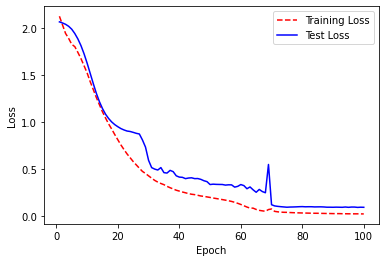

In [155]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

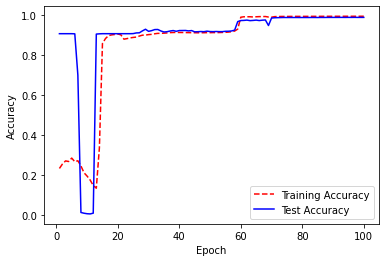

In [157]:
# Get training and test loss histories
training_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

#### Evaluate Results

We will predict the random training id (train_id). We will then visualise the results against the actual mask from the labels

In [38]:
train_id = random.randint(0, len(x_val)-1)
train_id

8

In [39]:
pred_mask = model.predict(np.expand_dims(x_val[train_id], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
print(np.unique(pred_mask[0]))
print(np.unique(y_val[train_id]))

[3]
[2. 5. 6. 7.]


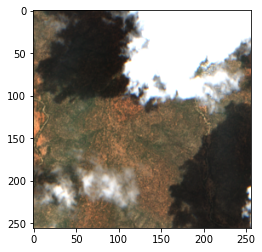

In [63]:
plt.imshow(x_train[19])

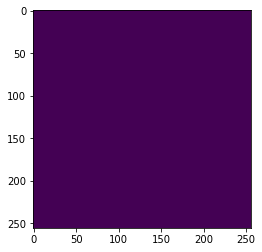

In [41]:
plt.imshow(pred_mask[0])

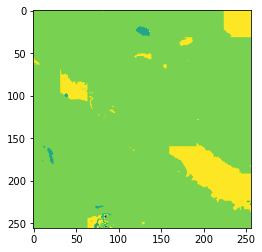

In [40]:
plt.imshow(y_val[train_id])

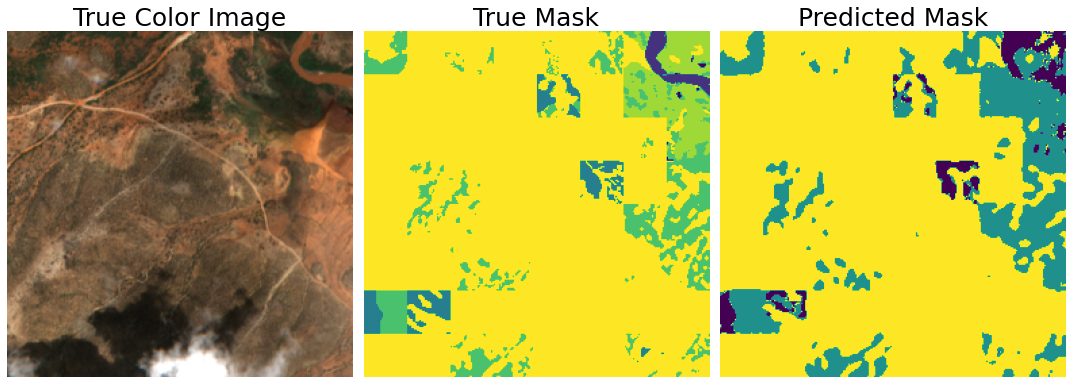

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,8))
# Perform a sanity check on some random training samples
plt.subplot(1, 3, 1)
fontsize =25
axes[0].imshow(x_train[train_id])
plt.title("True Color Image", fontdict={'fontsize': fontsize})
plt.axis('off')
plt.subplot(1, 3, 2)
axes[1].imshow(y_train[train_id])
#axes[1].imshow(np.mean(Y_test[0], axis=2))
plt.title("True Mask", fontdict={'fontsize': fontsize})
plt.axis('off')
plt.subplot(1,3,3)
axes[2].imshow(pred_mask[0]) #prdiction with threshold
plt.title("Predicted Mask", fontdict={'fontsize': fontsize})
plt.axis('off')
fig.tight_layout()
plt.savefig(tmp_dir+f'/landcovnet/fig_{train_testing_id}.png', dpi=200, edgecolor='w') 